In [23]:
# Pandas
import geopandas as gp
import pandas as pd

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt

import datetime as dt

# Plotly libraries
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# IPYWidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import numpy as np
import math

# Statsmodels libraries
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

# SKLEARN
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline
init_notebook_mode(connected = True)

### Import dataset if csv exists

In [2]:
if os.path.exists('./city_temperature.csv'):
    df = pd.read_csv('./city_temperature.csv',low_memory=False)
    df['Date'] = pd.to_datetime(df.loc[:,'Month':'Year'],dayfirst=True,errors='coerce')

### Print dataset head

In [3]:
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Date
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2,1995-01-01
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4,1995-01-02
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8,1995-01-03
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4,1995-01-04
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9,1995-01-05


In [4]:
df.describe()

,Month,Day,Year,AvgTemperature
count,2.906327e+06,2.906327e+06,2.906327e+06,2.906327e+06
mean,6.469163e+00,1.571682e+01,2.006624e+03,5.600492e+01
std,3.456489e+00,8.800534e+00,2.338226e+01,3.212359e+01
min,1.000000e+00,0.000000e+00,2.000000e+02,-9.900000e+01
25%,3.000000e+00,8.000000e+00,2.001000e+03,4.580000e+01
50%,6.000000e+00,1.600000e+01,2.007000e+03,6.250000e+01
75%,9.000000e+00,2.300000e+01,2.013000e+03,7.550000e+01
max,1.200000e+01,3.100000e+01,2.020000e+03,1.100000e+02


In [5]:
print(f"Number of unique Countries: {len(df.Country.unique())}")
print(f"Number of unique Cities: {len(df.City.unique())} ")

Number of unique Countries: 125
Number of unique Cities: 321 


# US

## Group By Day

In [6]:
df_us = df[df['Country']=='US'].groupby([pd.Grouper(key='Date',freq='D')]).mean().unstack(level=0).reindex().AvgTemperature

## Remove and Interpolate Default Vals (-99 F)

In [7]:
df_us.where(df_us>-99,inplace=True)
df_us.interpolate(method='time',inplace=True)

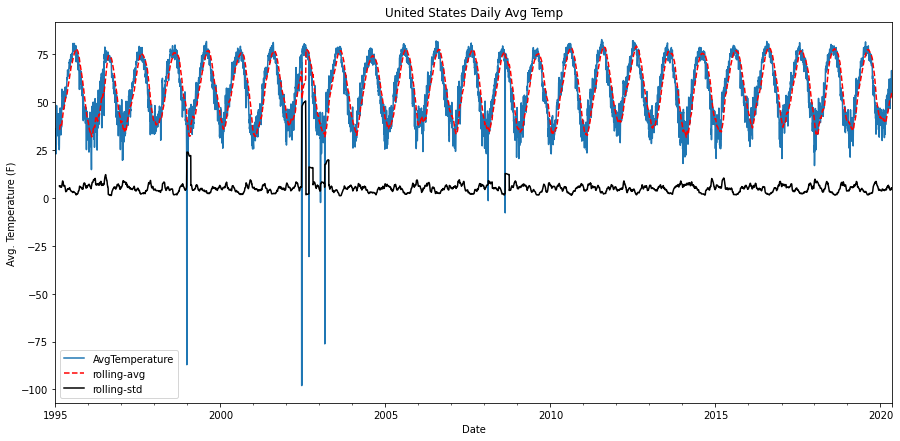

In [8]:
df_us.plot(title='United States Daily Avg Temp',figsize=(15,7),label='AvgTemperature')
df_us.rolling(window=45).mean().plot(color='r',linestyle='dashed',label='rolling-avg')
df_us.rolling(window=45).std().plot(color='black',label='rolling-std')
plt.ylabel('Avg. Temperature (F)')
plt.legend(loc='best')
plt.savefig('./Images/US/us_daily_avg_temp.jpeg')

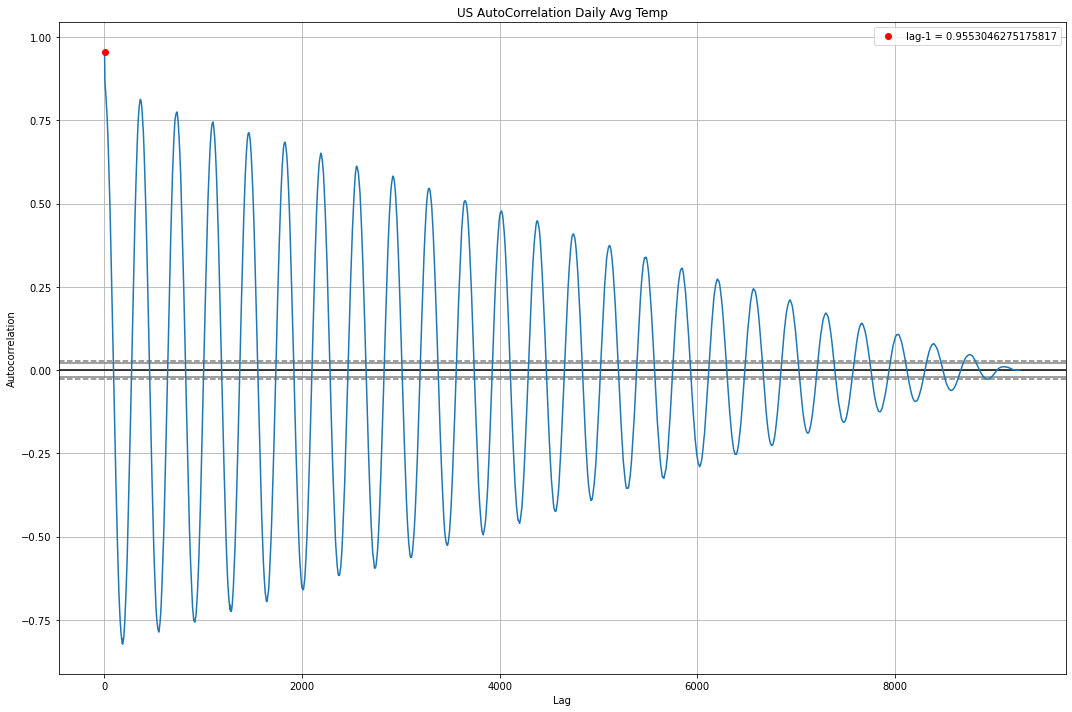

In [9]:
fig,ax=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_us,ax=ax)
plt.plot(1,df_us.autocorr(1),'ro',label=f'lag-1 = {df_us.autocorr(1)}')
plt.title('US AutoCorrelation Daily Avg Temp')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'./Images/US/us_autocorr_daily.jpeg')

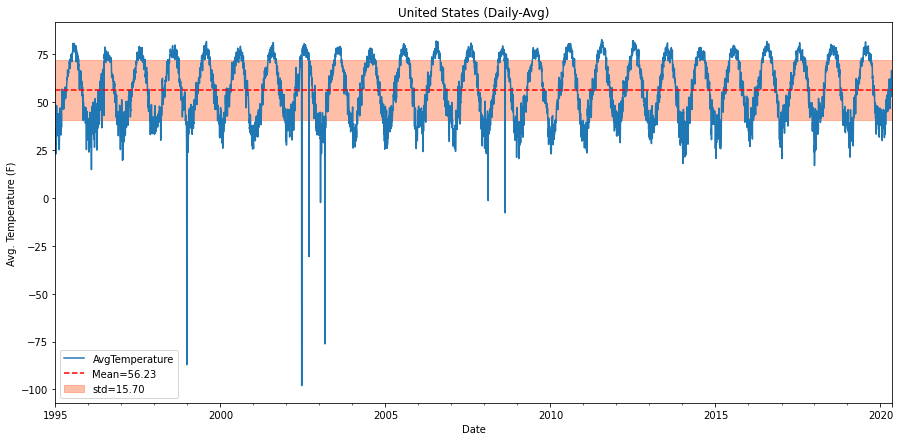

In [10]:
df_us.plot(title='United States (Daily-Avg)',figsize=(15,7),label='AvgTemperature')
plt.axhline(df_us.mean(),color='r',linestyle='dashed',label=f'Mean={df_us.mean():0.2f}')
plt.axhspan(df_us.mean()-df_us.std(),df_us.mean()+df_us.std(),alpha=0.5,color='coral',label=f'std={df_us.std():0.2f}')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/US/us_d_mean_std.jpeg')

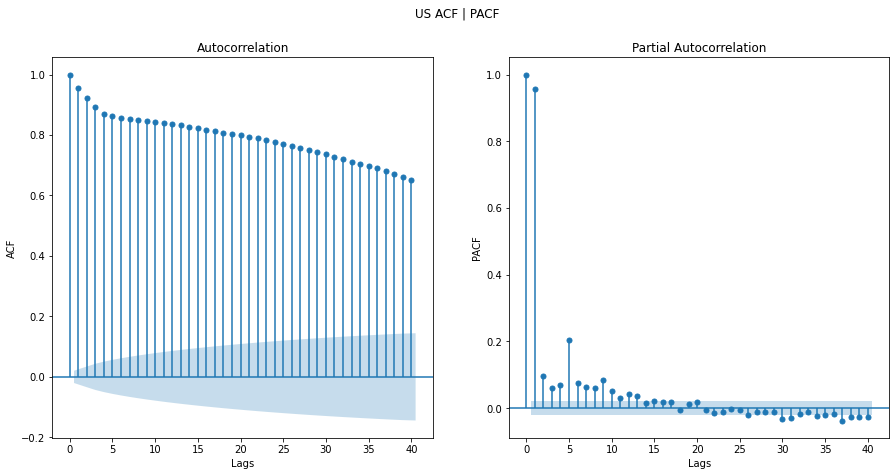

In [11]:
fig1,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7))

# Plot ACF 
plot_acf(df_us.values.squeeze(),lags=40,ax=ax1)

plt.suptitle('US ACF | PACF')

ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

# Plot PACF
plot_pacf(df_us,ax=ax2)

ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.savefig('./Images/US/acf_pacf_us.jpeg')

## Fit the model

### Train model on different parameters

In [12]:
mse = []
params = []
pvalues = []
for i in range(1,15):
    arm = ARIMA(df_us,order=(i,0,0)).fit()
    yhat = arm.predict()
    mse.append(np.linalg.norm(df_us-yhat)/df_us.size)

### Plot MSE vs. Parameter Values (all training data)

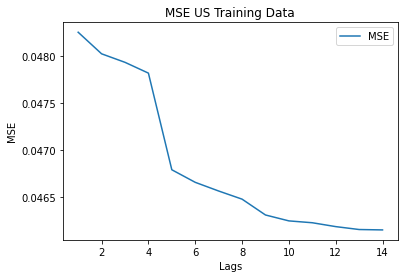

In [13]:
plt.plot(range(1,15),mse,label='MSE')
plt.ylabel('MSE')
plt.xlabel('Lags')
plt.title('MSE US Training Data')
plt.legend()
plt.savefig('./Images/US/us_mse_trainonly.jpeg')

## K-Fold Validation For Parameters

In [62]:
n-split=3
tscv = TimeSeriesSplit(n_splits=3)

In [63]:
mse_k = []
for i in range(1,15):
    mse_test = []
    mse_train = []
    count=0
    for train_idx, test_idx in tscv.split(df_us):
        count+=1
        train,test = df_us.iloc[train_idx],df_us.iloc[test_idx]
        model = ARIMA(train,order=(i,0,0)).fit()
        predict = model.predict(test.index.values[0],test.index.values[-1])
        true = test.values
        mse_test.append(np.linalg.norm(true-predict)/true.size)
        mse_train.append(np.linalg.norm(train.values-model.predict())/train.values.size)
    mse_k.append((np.mean(mse_test),np.mean(mse_train)))

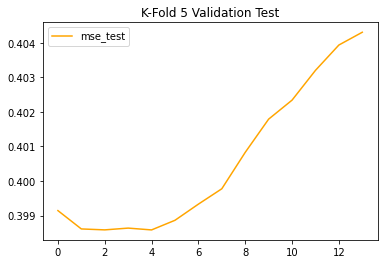

In [64]:
plt.plot([x[0] for x in mse_k],color='orange',label='mse_test')
plt.title(f'K-Fold {n-split} Validation Test')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/US/us_kfold{n-split}_test.jpeg')

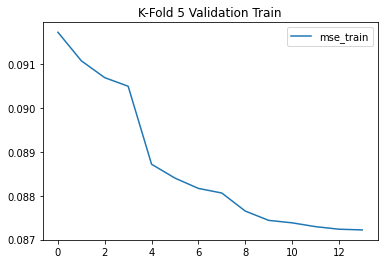

In [68]:
plt.plot([x[1] for x in mse_k],label='mse_train')
plt.title(f'United States K-Fold {n-split} Validation Train')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/US/us_kfold{n-split}_train.jpeg')

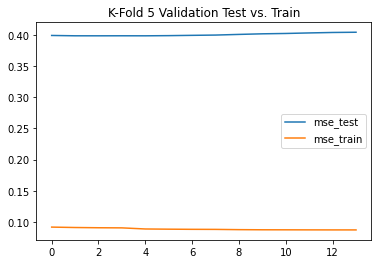

In [69]:
plt.plot([x[0] for x in mse_k],label='mse_test')
plt.plot([x[1] for x in mse_k],label='mse_train')
plt.title(f'United States K-Fold {n-split} Validation Test vs. Train')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/US/us_kfold{n-split}_test_train.jpeg')

In [73]:
model = ARIMA(train,order=(4,0,0)).fit()
model.params
model.pvalues

const     5.874276e-112
ar.L1      0.000000e+00
ar.L2      1.128714e-53
ar.L3      3.300264e-01
ar.L4      4.343249e-25
sigma2     0.000000e+00
dtype: float64

In [ ]:
y_hat = arm.predict()
test = arm.get_prediction(start=-25).predicted_mean

In [ ]:
arm.fittedvalues

In [ ]:
f = arm.forecast(25)

# Canada

## Group By Day

In [74]:
df_ca = df[df['Country']=='Canada'].groupby([pd.Grouper(key='Date',freq='D')]).mean().unstack(level=0).reindex().AvgTemperature

## Remove and Interpolate Default Vals (-99 F)

In [75]:
df_ca.where(df_ca>-99,inplace=True)
df_ca.interpolate(method='time',inplace=True)

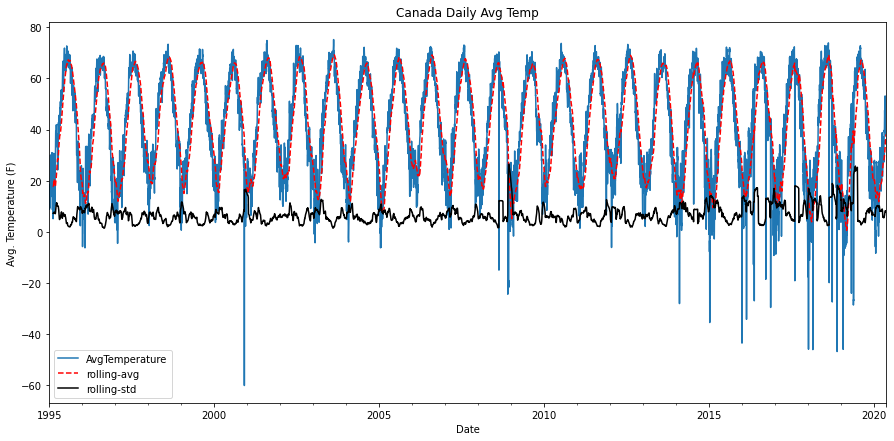

In [76]:
df_ca.plot(title='Canada Daily Avg Temp',figsize=(15,7),label='AvgTemperature')
df_ca.rolling(window=45).mean().plot(color='r',linestyle='dashed',label='rolling-avg')
df_ca.rolling(window=45).std().plot(color='black',label='rolling-std')
plt.ylabel('Avg. Temperature (F)')
plt.legend(loc='best')
plt.savefig('./Images/Canada/ca_daily_avg_temp.jpeg')

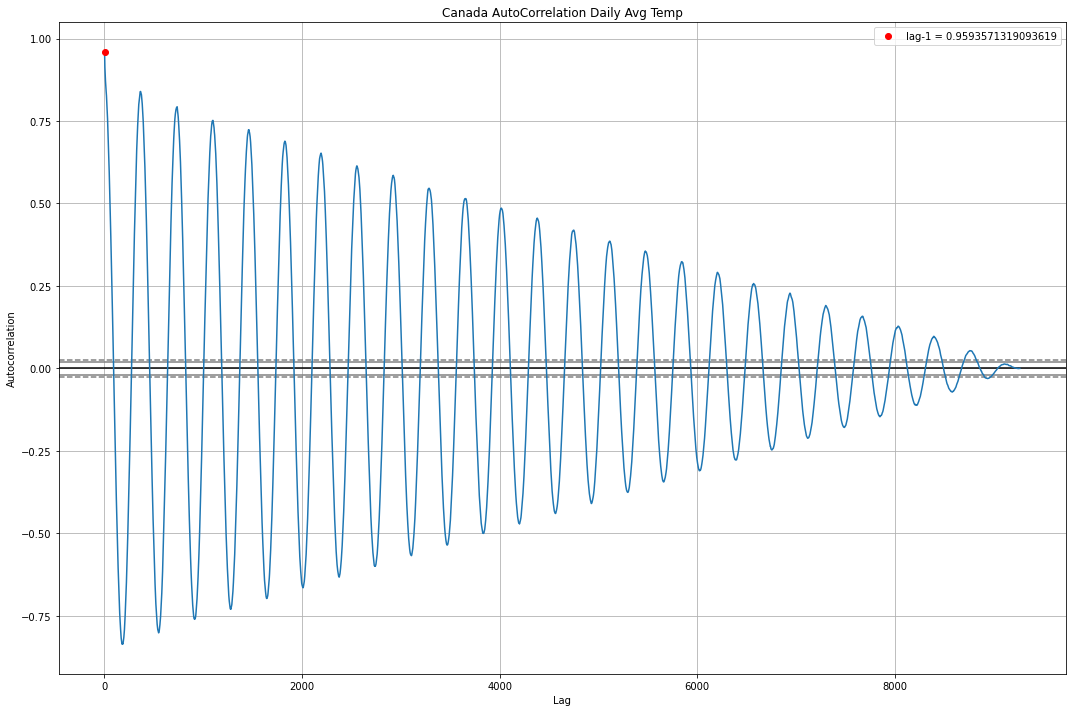

In [77]:
fig,ax=plt.subplots(figsize=(15,10))
pd.plotting.autocorrelation_plot(df_ca,ax=ax)
plt.plot(1,df_ca.autocorr(1),'ro',label=f'lag-1 = {df_ca.autocorr(1)}')
plt.title('Canada AutoCorrelation Daily Avg Temp')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'./Images/Canada/ca_autocorr_daily.jpeg')

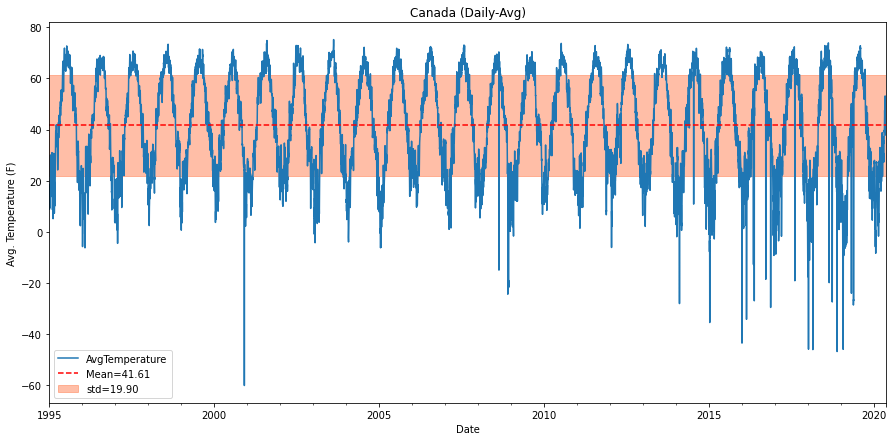

In [78]:
df_ca.plot(title='Canada (Daily-Avg)',figsize=(15,7),label='AvgTemperature')
plt.axhline(df_ca.mean(),color='r',linestyle='dashed',label=f'Mean={df_ca.mean():0.2f}')
plt.axhspan(df_ca.mean()-df_ca.std(),df_ca.mean()+df_ca.std(),alpha=0.5,color='coral',label=f'std={df_ca.std():0.2f}')
plt.ylabel('Avg. Temperature (F)')
plt.legend()
plt.savefig('./Images/Canada/ca_d_mean_std.jpeg')

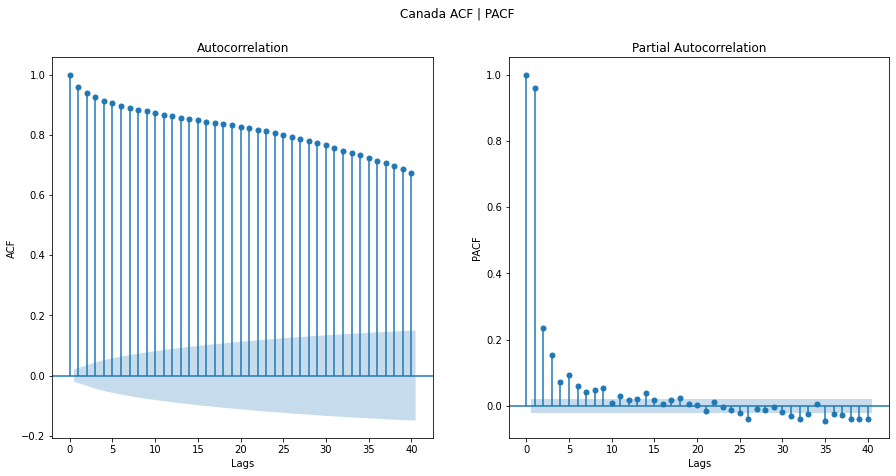

In [79]:
fig1,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7))

# Plot ACF 
plot_acf(df_ca.values.squeeze(),lags=40,ax=ax1)

plt.suptitle('Canada ACF | PACF')

ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

# Plot PACF
plot_pacf(df_ca,ax=ax2)

ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.savefig('./Images/Canada/acf_pacf_ca.jpeg')

## Fit the model

### Train model on different parameters

In [81]:
mse = []
params = []
pvalues = []
for i in range(1,10):
    arm = ARIMA(df_ca,order=(i,0,0)).fit()
    yhat = arm.predict()
    mse.append(np.linalg.norm(df_ca-yhat)/df_ca.size)

### Plot MSE vs. Parameter Values (all training data)

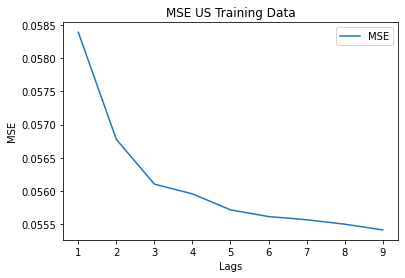

In [82]:
plt.plot(range(1,10),mse,label='MSE')
plt.ylabel('MSE')
plt.xlabel('Lags')
plt.title('MSE Canada Training Data')
plt.legend()
plt.savefig('./Images/Canada/ca_mse_trainonly.jpeg')

## K-Fold Validation For Parameters

In [83]:
n-split= 3
tscv = TimeSeriesSplit(n_splits=n-split)
mse_k = []
for i in range(1,10):
    mse_test = []
    mse_train = []
    count=0
    for train_idx, test_idx in tscv.split(df_ca):
        count+=1
        train,test = df_ca.iloc[train_idx],df_ca.iloc[test_idx]
        model = ARIMA(train,order=(i,0,0)).fit()
        predict = model.predict(test.index.values[0],test.index.values[-1])
        true = test.values
        mse_test.append(np.linalg.norm(true-predict)/true.size)
        mse_train.append(np.linalg.norm(train.values-model.predict())/train.values.size)
    mse_k.append((np.mean(mse_test),np.mean(mse_train)))

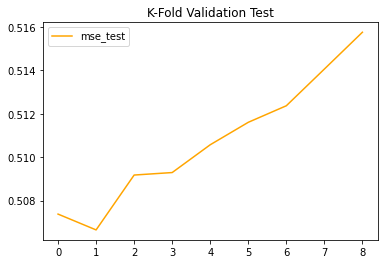

In [84]:
plt.plot([x[0] for x in mse_k],color='orange',label='mse_test')
plt.title(f'Canada K-Fold {n-split} Validation Test')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/Canada/ca_kfold{n-split}_test.jpeg')

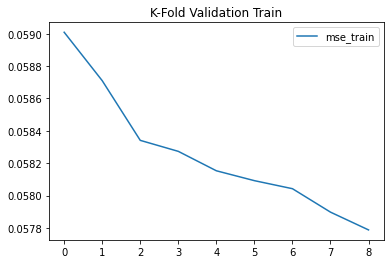

In [85]:
plt.plot([x[1] for x in mse_k],label='mse_train')
plt.title('Canada K-Fold Validation Train')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/Canada/ca_kfold{n-split}_train.jpeg')

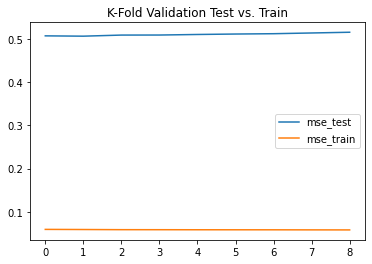

In [86]:
plt.plot([x[0] for x in mse_k],label='mse_test')
plt.plot([x[1] for x in mse_k],label='mse_train')
plt.title(f'Canada K-Fold {n-split} Validation Test vs. Train')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.savefig(f'./Images/Canada/ca_kfold{n-split}_test_train.jpeg')

In [ ]:
arm.pvalues

In [ ]:
y_hat = arm.predict()
test = arm.get_prediction(start=-25).predicted_mean

In [ ]:
arm.fittedvalues

In [ ]:
f = arm.forecast(25)

In [ ]:
f